In [52]:
import pandas as pd
from scapy.all import rdpcap
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler

In [53]:
def plotIAT(df):
    # display(df['Interarrival'])

    # Plot the interarrival times
    plt.plot(df.index, df['Interarrival'], marker='o')
    plt.xlabel('Packet Number')
    plt.ylabel('Interarrival Time')
    plt.title('Interarrival Times of Packets')
    plt.grid(True)
    plt.show()


def plotIAT_minmax(df):
    # display(df['Interarrival'])

    # Plot the interarrival times
    plt.plot(df.index, df['Interarrival_scaled'], marker='o')
    plt.xlabel('Packet Number')
    plt.ylabel('Interarrival Time')
    plt.title('Interarrival Times of Packets')
    plt.grid(True)
    plt.show()

In [54]:
# data = 'data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Discord/1620974392_com.discord_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json'
# data = 'data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Discord/1639474620_com.discord_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json'
# data = 'data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Discord/1637319936_com.discord_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json'

data = "data/pcap/MIRAGE-COVID-CCMA-2022/Raw_JSON/Teams/1626165196_com.microsoft.teams_mirage2020dataset_labeled_biflows_all_packets_encryption_metadata.json"

# Open the JSON file
with open(data, 'r') as file:
    # Load the JSON data into a Python dictionary
    data = json.load(file)

biflows = list(data.keys())

print("biflows: ", biflows)
print('number of biflows: ', len(biflows))

biflows:  ['192.168.20.100,44406,52.114.74.63,443,6', '192.168.20.100,33290,8.8.8.8,853,6', '192.168.20.100,57439,52.113.194.132,443,6', '192.168.20.100,58148,52.114.36.3,443,6', '192.168.20.100,57416,52.113.194.132,443,6', '192.168.20.100,57415,52.113.194.132,443,6', '192.168.20.100,57445,52.113.194.132,443,6', '192.168.20.100,50412,52.113.194.132,443,6', '192.168.20.100,57419,52.113.194.132,443,6', '192.168.20.100,60437,13.107.18.11,443,6', '192.168.20.100,56136,52.114.104.11,443,6', '192.168.20.100,42949,20.190.159.131,443,6', '192.168.20.100,54656,52.114.104.166,443,6', '192.168.20.100,49276,52.114.76.60,443,6', '192.168.20.100,49277,52.114.76.60,443,6', '192.168.20.100,49278,52.114.76.60,443,6', '192.168.20.100,33912,52.114.76.114,443,6', '192.168.20.100,49280,52.114.76.60,443,6', '192.168.20.100,46941,52.114.92.151,443,6', '192.168.20.100,60870,52.114.104.55,443,6', '192.168.20.100,56752,52.113.194.132,443,6', '192.168.20.100,57491,52.113.194.132,443,6', '192.168.20.100,45826,52.

In [55]:
# Selecting the second biflow
currentBiflow = biflows[45]

# Biflows organised as: srcIP, srcPort, dstIP, dstPort, protocolNum
srcIP, srcPort, dstIP, dstPort, protocolNum = currentBiflow.split(",")

biflowPacketData = data[currentBiflow]['packet_data']

payloadSizeArr = biflowPacketData['L4_payload_bytes']
payloadSizeArr = np.array(payloadSizeArr)

# Find indices of elements with value 0
zero_indices = np.where(payloadSizeArr == 0)[0]

# Finding all iat in the biflow
biflowIAT = biflowPacketData['iat']

iat_df = pd.DataFrame({'Interarrival': biflowIAT})

# Removal of payload length 0 packets
cleaned_iat_df = iat_df.drop(zero_indices)
cleaned_iat_df = cleaned_iat_df.reset_index(drop=True)

cleaned_iat_df['Interarrival'].quantile(0.99)

29.8412408

percentile_99:  29.8412408
length before saturation to 99th percentile:  537
length after saturation to 99th percentile:  537
original length:  537
new length:  537


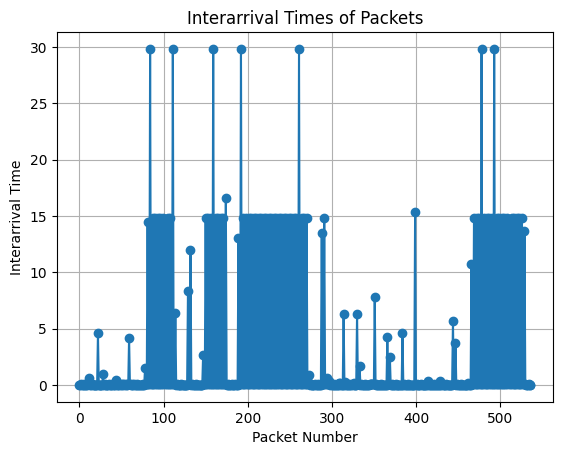

In [58]:
# Saturation to the 99th percentile
# Calculate the 99th percentile
percentile_99 = cleaned_iat_df['Interarrival'].quantile(0.99)

print("percentile_99: ", percentile_99)
print("length before saturation to 99th percentile: ", len(cleaned_iat_df))
# Saturation to the 99th percentile
cleaned_iat_df['Interarrival'] = iat_df['Interarrival'].apply(
    lambda x: min(x, percentile_99))
print("length after saturation to 99th percentile: ", len(cleaned_iat_df))

# # Re-scaling to achieve a minimum granularity of 1 microsecond
# iat_df['Interarrival'] *= 1e6

print("original length: ", len(iat_df))
print("new length: ", len(cleaned_iat_df))

# display(cleaned_iat_df)
plotIAT(cleaned_iat_df)

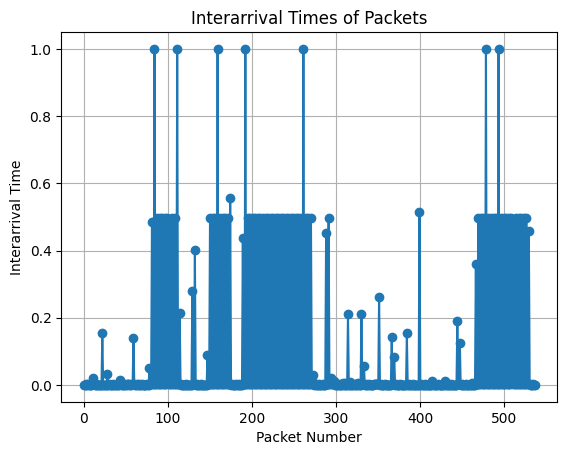

In [59]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
cleaned_iat_df['Interarrival_scaled'] = scaler.fit_transform(
    cleaned_iat_df[['Interarrival']])

plotIAT_minmax(cleaned_iat_df)

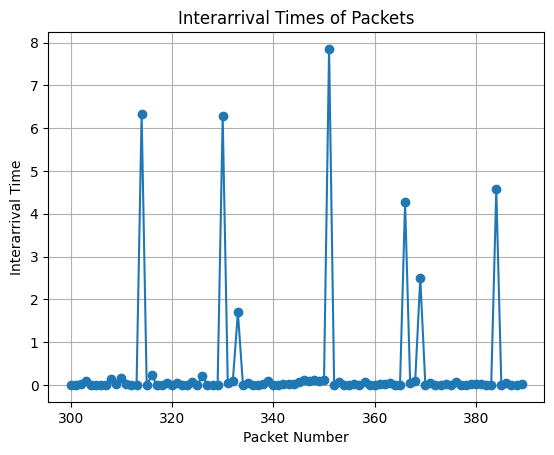

In [64]:
sliced_df = cleaned_iat_df.iloc[300:390]

plotIAT(sliced_df)

In [ ]:
def aggregate_IAT(biflows_data):
    all_iat_data = []

    for currentBiflow, biflow_data in biflows_data.items():
        biflowPacketData = biflow_data['packet_data']

        # Extract payload size array
        # payloadSizeArr = biflowPacketData['L4_payload_bytes']
        # payloadSizeArr = np.array(payloadSizeArr)

        # # Find indices of elements with value 0
        # zero_indices = np.where(payloadSizeArr == 0)[0]

        # Extract interarrival times
        biflowIAT = biflowPacketData['iat']

        # Remove payload length 0 packets
        # cleaned_iat = np.delete(biflowIAT, zero_indices)

        # Append interarrival times to the list
        # all_iat_data.extend(cleaned_iat)
        all_iat_data.extend(biflowIAT)

    # Create a DataFrame from aggregated interarrival times
    iat_df = pd.DataFrame({'Interarrival': all_iat_data})

    return iat_df

In [ ]:
test_df = aggregate_IAT(data)

percentile_99 = test_df["Interarrival"].quantile(0.99)
test_df['Interarrival'] = test_df['Interarrival'].apply(
    lambda x: min(x, percentile_99))

# display(test_df)
plotIAT(test_df)

print("99th Percentile: ", test_df["Interarrival"].quantile(0.99))